In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Prediction sales for Next 3 month in daily , Weeklt,Monthly Sales**

In [109]:
import os
import pandas as pd

def creat_overall_items_sales(path):

  file_list = [path + f for f in os.listdir(path) if f.startswith('item_')]
  csv_list = []
  
  for file in sorted(file_list):
    csv_list.append(pd.read_csv(file).assign(File_Name = os.path.basename(file)))

  csv_merged = pd.concat(csv_list, ignore_index=True)
  csv_merged.to_csv(path + 'sales_records_full.csv', index=False)

In [110]:
path = "/content/drive/MyDrive/data_row/"
creat_overall_items_sales(path)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [131]:
items_sales = pd.read_csv('/content/drive/MyDrive/data_row/sales_records_full.csv',index_col=False)

In [132]:
items_sales.head()

,Unnamed: 0,_id,date,quantity,revenue,ordersCount,File_Name
0,0,61b7404307b79a564847b3ae,2021-01-01,61,549.0,35,item_1.csv
1,1,61b7404307b79a564847b3d4,2021-01-02,69,621.0,38,item_1.csv
2,2,61b7404307b79a564847b404,2021-01-03,30,270.0,20,item_1.csv
3,3,61b7404307b79a564847b42d,2021-01-04,62,558.0,34,item_1.csv
4,4,61b7404307b79a564847b46a,2021-01-05,68,612.0,44,item_1.csv


In [133]:
items_sales.describe()

,Unnamed: 0,quantity,revenue,ordersCount
count,4244.000000,4244.000000,4244.000000,4244.000000
mean,134.836239,10.537229,178.911227,7.930961
std,93.341980,12.446152,221.611591,8.230202
min,0.000000,1.000000,7.826000,1.000000
25%,58.000000,2.000000,39.782500,2.000000
50%,118.500000,6.000000,109.564000,5.000000
75%,196.000000,14.000000,234.780000,11.000000
max,363.000000,157.000000,3150.000000,97.000000


In [134]:
items_quantity = items_sales.drop(['_id',"revenue","quantity","File_Name"], axis=1)

In [135]:
del items_quantity["Unnamed: 0"]

In [136]:
items_quantity.head()

,date,ordersCount
0,2021-01-01,35
1,2021-01-02,38
2,2021-01-03,20
3,2021-01-04,34
4,2021-01-05,44


In [137]:
items_orders = items_quantity.copy()
monthly_order = items_quantity.copy()
weekly_order = items_quantity.copy()
monthly_order.head()

,date,ordersCount
0,2021-01-01,35
1,2021-01-02,38
2,2021-01-03,20
3,2021-01-04,34
4,2021-01-05,44


In [138]:
def items_date_consumer(data,consumer_type):
  data["date"] = pd.to_datetime(data['date'])
  data['date'] = data['date'].dt.to_period(consumer_type)
  final_data = data.groupby('date').sum().reset_index()
  final_data['date'] = final_data['date'].dt.to_timestamp()
  return final_data


In [139]:
items_weekly_order= items_date_consumer(weekly_order,"W")
items_monthly_order= items_date_consumer(monthly_order,"M")
items_daily_orders = items_date_consumer(items_orders,"D")

In [140]:
items_daily_orders.head()

,date,ordersCount
0,2021-01-01,161
1,2021-01-02,169
2,2021-01-03,158
3,2021-01-04,201
4,2021-01-05,179


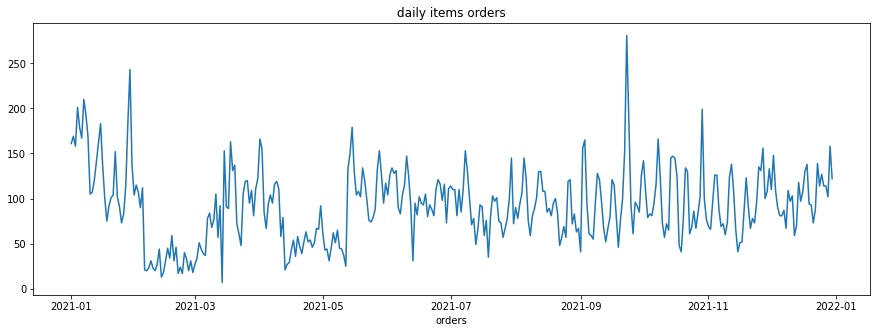

In [141]:
plt.figure(figsize=(15,5))
plt.plot(items_daily_orders['date'], items_daily_orders['ordersCount'])
plt.xlabel('Date')
plt.xlabel('orders')
plt.title("daily items orders")
plt.show()

In [142]:
def train_sales_forcasting(data,valid_horizon,target):

  if "date" in data.columns:
    data.drop("date",axis=1,inplace=True)

  train = data.head(-valid_horizon).copy()
  y_valid = data.tail(valid_horizon)[target]
  column_name = "lag"+str(valid_horizon)
  train[column_name] = train[target].shift(valid_horizon)
  train_without_nulls = train.dropna()
  X_train = train_without_nulls.drop(columns=target)
  y_train = train_without_nulls[target]
  lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)

  return y_train , lr ,y_valid


In [143]:
def prediction_sales(ytrain,prediction_model,forcasting_period):
  
  forcasting_sales = ytrain.tail(forcasting_period).values
  X_valid1 = pd.DataFrame({
    'lag-period': forcasting_sales})
  sales_prediction = prediction_model.predict(X_valid1)
  return sales_prediction
  

In [144]:
y_daily_train ,daily_model ,daily_vaildation_data = train_sales_forcasting(items_daily_orders,90,'ordersCount')
y_weekly_train ,weekly_model, weekly_vaildation_data= train_sales_forcasting(items_weekly_order,12,'ordersCount')
y_montly_train ,monthly_model, monthly_vaildation_data = train_sales_forcasting(items_monthly_order,3,'ordersCount')

In [ ]:
daily_sales_next_3month = prediction_sales(y_daily_train,daily_model,90)
monthly_sales_next_3month = prediction_sales(y_montly_train,monthly_model,3)
weekly_sales_next_3month = prediction_sales(y_weekly_train,weekly_model,12)

In [146]:
daily_sales_next_3month

array([ 65.47199768,  88.91258944,  68.70518275,  89.72088571,
       123.66932895, 105.0785148 ,  80.82962677,  57.38903501,
        63.04710888,  39.60651712,  53.34755367,  75.17155289,
        73.55496036,  47.68947979,  61.43051634,  28.29036937,
        63.85540515,  83.25451557,  78.40473796,  81.63792304,
        60.62222008,  59.00562754,  46.07288726,  54.15584993,
        63.04710888,  80.82962677, 117.20295881,  58.19733127,
        72.74666409,  63.04710888,  75.97984916,  85.67940437,
       117.20295881,  99.42044092,  61.43051634,  47.68947979,
        65.47199768,  71.93836782,  81.63792304, 105.0785148 ,
       105.0785148 ,  87.29599691,  87.29599691,  68.70518275,
        71.93836782,  65.47199768,  76.78814543,  80.82962677,
        67.89688648,  38.79822085,  46.07288726,  55.77244247,
        46.07288726,  96.18725585,  97.80384839,  58.19733127,
        67.08859022,  50.92266486,  54.15584993,  33.14014697,
       126.09421776, 133.36888417,  76.78814543,  49.30

In [147]:
monthly_sales_next_3month

array([2486.93884297, 2521.96615062, 2734.82440478])

In [148]:
weekly_sales_next_3month

array([514.08048768, 556.08351154, 621.82737498, 682.09258312,
       531.42956276, 527.7771259 , 591.6947709 , 566.1277129 ,
       511.34116004, 865.62753521, 664.74350805, 672.96149098])

In [154]:
from sklearn.metrics import mean_absolute_error
def plot_mea (validation_data,prediction_data):
  mae = np.round(mean_absolute_error(validation_data, prediction_data), 3)    
      
  #plot reality vs prediction for the last week of the dataset
  fig = plt.figure(figsize=(16,8))
  plt.title(f'forcasting for next 3 month - MAE {mae}', fontsize=20)
  plt.plot(validation_data, color='red')
  plt.plot(pd.Series(prediction_data, index=validation_data.index), color='green')
  plt.xlabel('time', fontsize=16)
  plt.ylabel('sales', fontsize=16)
  plt.legend(labels=['Real', 'Prediction'], fontsize=16)
  plt.grid()
  plt.show()

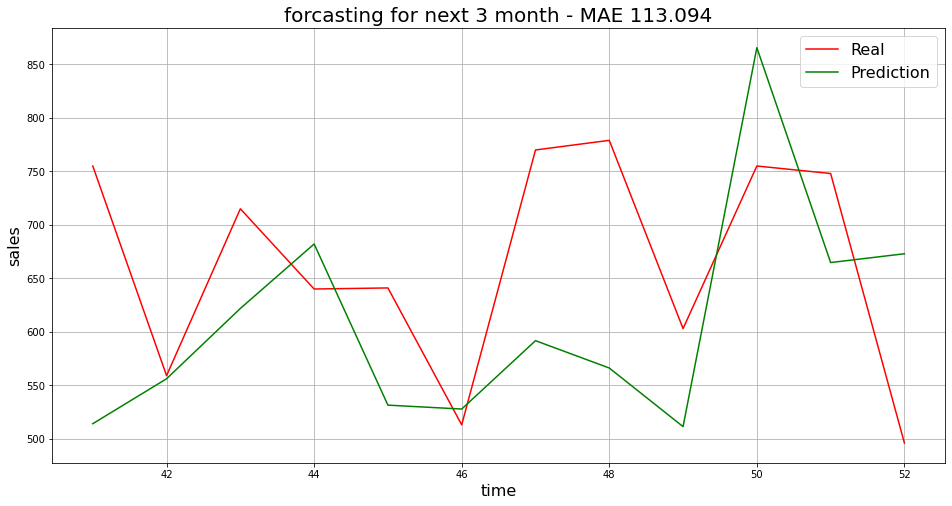

In [155]:
plot_mea(weekly_vaildation_data,weekly_sales_next_3month)

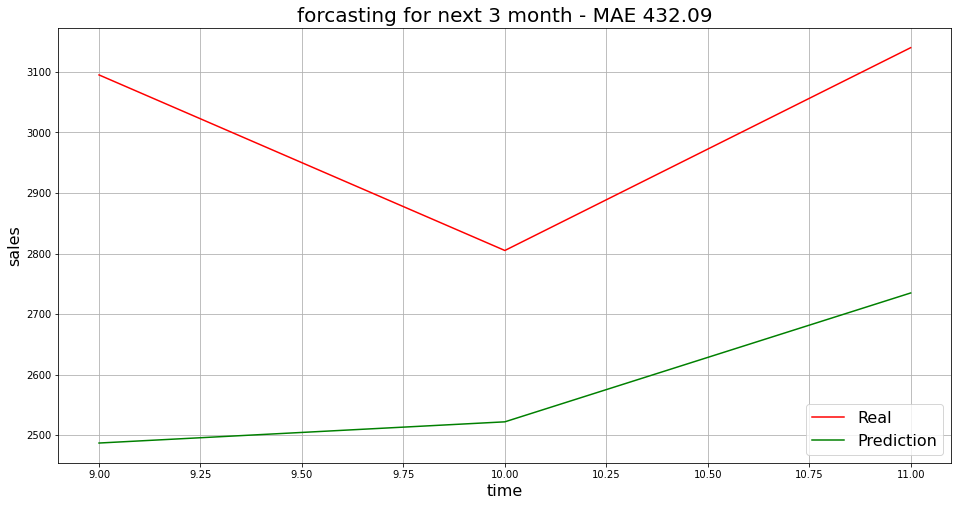

In [156]:
plot_mea(monthly_vaildation_data,monthly_sales_next_3month)

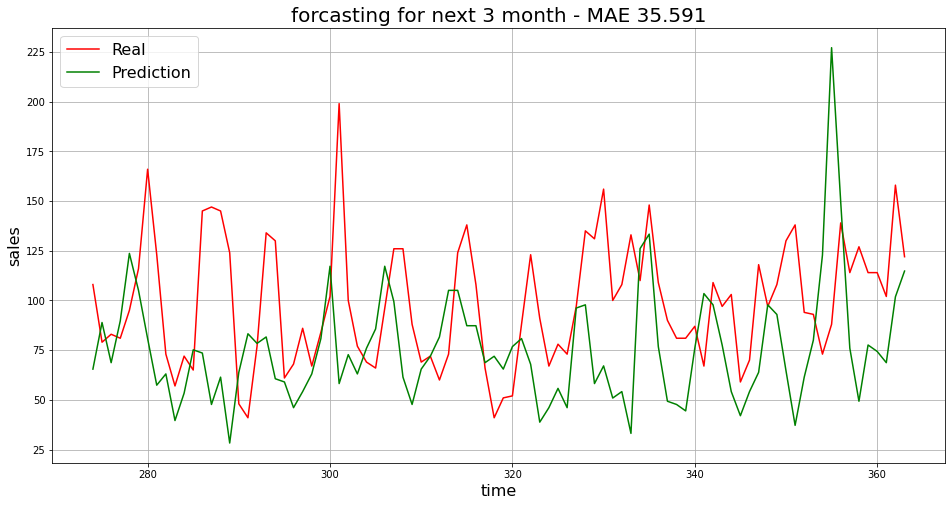

In [157]:
plot_mea(daily_vaildation_data,daily_sales_next_3month)

# **Overall MAPE Of Item in Week,Month,Days for Next 3 month**

In [105]:
def calculate_mape(actual, predicted) -> float:
  
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)
  
    return round(np.mean(np.abs((
      actual - predicted) / actual)) * 100, 2)

In [83]:
item1_sales = pd.read_csv("/content/drive/MyDrive/data_row/item_1.csv")
item1_orders = item1_sales[["date","ordersCount"]]
item1_montly = item1_orders.copy()
item1_daily = item1_orders.copy()
item1_weekly = item1_orders.copy()
item1_daily_orders = items_date_consumer(item1_daily,"D")
item1_weekly_order = items_date_consumer(item1_weekly,"W")
item1_monthly_order = items_date_consumer(item1_montly,"M")


In [78]:
y_item1_daily_train ,item1_daily_model ,item1_daily_vaildation_data = train_sales_forcasting(item1_daily_orders,90,'ordersCount')
y_item1_weekly_train ,item1_weekly_model ,item1_weekly_vaildation_data = train_sales_forcasting(item1_weekly_order,12,'ordersCount')
y_item1_monthly_train ,item1_monthly_model ,item1_monthly_vaildation_data = train_sales_forcasting(item1_monthly_order,3,'ordersCount')

In [ ]:
item1_daily_sales_next_3month = prediction_sales(y_item1_daily_train,item1_daily_model,90)
item1_monthly_sales_next_3month = prediction_sales(y_item1_monthly_train,item1_monthly_model,3)
item1_weekly_sales_next_3month = prediction_sales(y_item1_weekly_train,item1_weekly_model,12)

In [88]:
daily_item1_overall_mape = calculate_mape(np.array(item1_daily_vaildation_data),item1_daily_sales_next_3month)
monthly_item1_overall_mape = calculate_mape(np.array(item1_monthly_vaildation_data),item1_monthly_sales_next_3month)
weekly_item1_overall_mape = calculate_mape(np.array(item1_weekly_vaildation_data),item1_weekly_sales_next_3month)


In [103]:
item1_mape = {"monthly_mape":monthly_item1_overall_mape,"weekly_mape":weekly_item1_overall_mape,"daily_mape":daily_item1_overall_mape}
over_all_mape = pd.DataFrame.from_dict(item1_mape,orient = 'index',columns = ["mape %"])

In [104]:
over_all_mape

,mape %
monthly_mape,9.33
weekly_mape,20.06
daily_mape,44.49


# **Prediction Branch Revenue for Next 1 Month**

In [114]:
branch_data = pd.read_csv("/content/drive/MyDrive/data_row/Branch_Revenue.csv",index_col=0)

In [115]:
branch_revenue = branch_data.drop(['_id',"ordersCount"], axis=1)

In [116]:
daily_revenue = branch_revenue.copy()

In [117]:
branch_daily_revenue= items_date_consumer(daily_revenue,"D")

In [118]:
y_branch_daily_train ,branch_daily_model ,branch_daily_vaildation_data = train_sales_forcasting(branch_daily_revenue,30,'revenue')


In [ ]:
daily_sales_next_month = prediction_sales(y_branch_daily_train,branch_daily_model,30)


In [121]:
daily_sales_next_month

array([2251.30604915, 2137.65852403, 2700.93030729, 3517.26076387,
       3646.08622761, 2649.17085445, 2021.17631404, 2002.93824433,
       2083.96146826, 2412.88293988, 3655.0854115 , 4294.08037511,
       3054.36016332, 1718.67776885, 1485.48480358, 1940.93833073,
       1756.95526071, 2841.51145374, 3499.69388899, 2196.73851233,
       2189.13168662, 2195.68123719, 1989.16971197, 2983.90337127,
       4774.37384891, 4294.87796091, 4485.4906781 , 3234.54562565,
       3975.14731716, 4108.68451861])

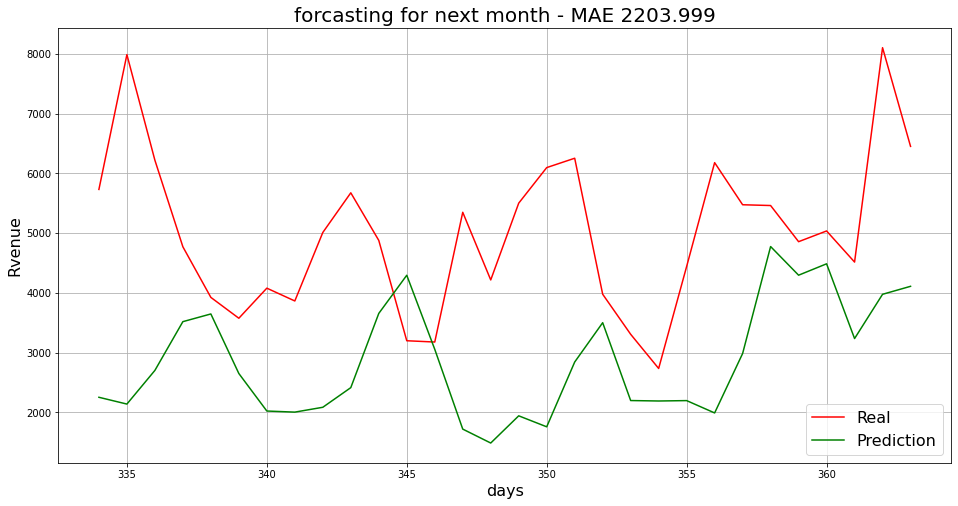

In [158]:
from sklearn.metrics import mean_absolute_error
mae = np.round(mean_absolute_error(branch_daily_vaildation_data, daily_sales_next_month), 3)    
    
#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,8))
plt.title(f'forcasting for next month - MAE {mae}', fontsize=20)
plt.plot(branch_daily_vaildation_data, color='red')
plt.plot(pd.Series(daily_sales_next_month, index=branch_daily_vaildation_data.index), color='green')
plt.xlabel('days', fontsize=16)
plt.ylabel('Rvenue', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()